In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from matplotlib import pyplot as plt

2023-06-05 21:59:18.636444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile and load the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights("best_model.hdf5")
print("Model loaded")

Model loaded


In [56]:
# Define the sliding window algorithm
def sliding_window(scale, image):
    start_x = 0
    start_y = 0
    height, width, _ = image.shape
    end_x = start_x + scale
    end_y = start_y + scale
    expanded_images = []
    points = []
    while end_y < height:
        while end_x < width:
            subsection = image[start_y:end_y, start_x:end_x]
            resized_img = cv2.resize(subsection, (224, 224))
            normalized_img = resized_img / 255.0
            expanded_img = np.expand_dims(normalized_img, axis=0) # For the batch size
            expanded_images.append(expanded_img)
            points.append((start_x, start_y, end_x, end_y))
            start_x += int(scale / 2)
            end_x = start_x + scale
        start_x = 0
        end_x = start_x + scale
        start_y += int(scale / 2)
        end_y = start_y + scale
    predictions = model.predict(np.vstack(expanded_images))
    relevant = predictions > 0.97
    points = np.asarray(points)
    return points[relevant.flatten()]

In [54]:
# Run the sliding window algorithm for multiple scaled windows
scales = [50, 75, 100]
test_img = cv2.imread("data/test/test1.jpg")
all_boundaries = []
for scale in scales:
    curr_bounds = sliding_window(scale=scale, image=test_img)
    all_boundaries.append(curr_bounds)

10/10 [==============================] - 2s 220ms/step


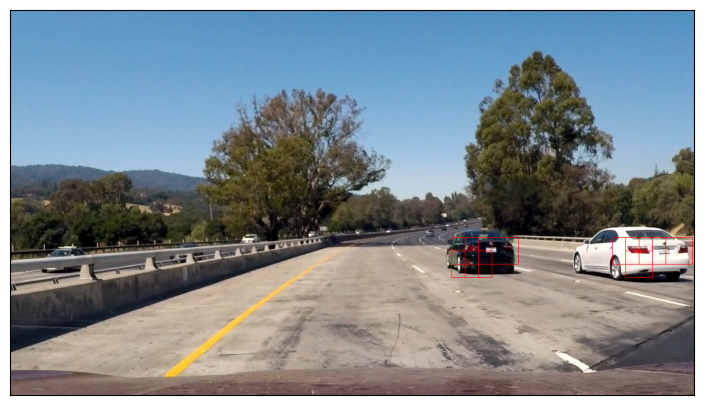

In [55]:
for x_1, y_1, x_2, y_2 in all_boundaries[0]:
    cv2.rectangle(test_img, (x_1, y_1), (x_2, y_2), (0, 0, 255))
plt.rcParams['figure.figsize'] = [10, 5]
plt.tick_params(left=False, right=False, labelleft = False, labelbottom=False, bottom=False)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.savefig("temp1.jpg", bbox_inches="tight")
plt.show()